In [4]:
import os

# Path to the directory
dataset_path = "/kaggle/input/databease-1"

# List all files in the directory to check the contents
files = os.listdir(dataset_path)
print("Files in the dataset directory:", files)


Files in the dataset directory: ['databasae']


In [5]:
import os
import pandas as pd

# Correct the dataset path based on the printed available directories
dataset_path = "/kaggle/input/databease-1"

# List all files in the dataset directory
files = os.listdir(dataset_path)
print("Files in the dataset directory:", files)

# Load CSV files and display their contents
for file in files:
    if file.endswith(".csv"):
        file_path = os.path.join(dataset_path, file)
        data = pd.read_csv(file_path)
        print(f"First 5 rows of {file}:")
        print(data.head())


Files in the dataset directory: ['databasae']


In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import random
from tqdm import tqdm  # Import tqdm for progress bar

# Load the EEG data
df = pd.read_csv('/kaggle/input/databease-1/databasae/S01G2AllChannels.csv')  # Adjust the file path accordingly
channels = ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']

# Calculate time values based on 300 seconds for 38,252 rows
total_time = 300  # Total duration in seconds
num_rows = len(df)  # Number of rows (38252)
time_step = total_time / num_rows  # Time step per row
time_axis = np.arange(0, total_time, time_step)  # Time array for the x-axis

# Fitness function to evaluate performance
def calculate_fitness(original_signal, reconstructed_signal):
    mse = mean_squared_error(original_signal, reconstructed_signal)
    pcc, _ = pearsonr(original_signal, reconstructed_signal)
    snr = 10 * np.log10(np.sum(np.square(original_signal)) / np.sum(np.square(original_signal - reconstructed_signal)))

    # Minimize MSE, maximize SNR, maximize PCC
    fitness = -mse + (snr * 10) + (pcc * 100)  # Weighted combination (you can adjust weights)
    return fitness, mse, snr, pcc

# BSA Encoding Algorithm
def BSA_encode(S, thresholdBSA):
    # Create a binary spike train based on the threshold
    B = (S > thresholdBSA).astype(int)
    S_modified = S * B
    return B, S_modified

# Moving-Window Encoding Algorithm
def moving_window_encode(S, window_size, threshold):
    # Create a spike train with the same length as the original signal
    spikes = np.zeros(len(S))

    for i in range(len(S) - window_size + 1):
        window = S[i:i + window_size]
        if np.mean(window) > threshold:
            spikes[i + window_size - 1] = 1  # Mark the end of the window

    return spikes

# Signal Reconstruction from spikes
def reconstruct_signal(S_spikes, S_original):
    # Reconstruct signal based on spikes
    return S_spikes * S_original  # Simple linear reconstruction for demonstration

# PSO Parameters
num_particles = 10
num_iterations = 20
inertia_weight = 0.7
cognitive_weight = 1.5
social_weight = 1.5

# Initialize particle population
def initialize_particles(size):
    particles = []
    for _ in range(size):
        # Randomly initialize thresholds for both BSA and MW, and window sizes
        position = (
            random.uniform(0.0, 1.0),  # Threshold BSA
            random.uniform(0.0, 1.0),  # Threshold MW
            random.randint(5, 100)     # Window size
        )
        velocity = (
            random.uniform(-0.1, 0.1),  # Velocity for BSA threshold
            random.uniform(-0.1, 0.1),  # Velocity for MW threshold
            random.randint(-5, 5)       # Velocity for window size
        )
        particles.append((position, velocity, position))  # (position, velocity, personal best)
    return particles

# Main PSO Loop
def particle_swarm_optimization():
    particles = initialize_particles(num_particles)
    global_best_position = None
    global_best_fitness = -np.inf

    for iteration in tqdm(range(num_iterations), desc="Running Iterations"):
        for i in range(num_particles):
            position, velocity, personal_best = particles[i]

            # Assume we're processing the first channel for simplicity
            eeg_channel_data = df[channels[0]].values
            
            # Apply BSA and reconstruct
            spike_train_bsa, modified_signal_bsa = BSA_encode(eeg_channel_data, position[0])
            reconstructed_bsa = reconstruct_signal(spike_train_bsa, eeg_channel_data)
            
            # Apply MW and reconstruct
            spike_train_mwe = moving_window_encode(eeg_channel_data, int(position[2]), position[1])
            reconstructed_mwe = reconstruct_signal(spike_train_mwe, eeg_channel_data)

            # Calculate fitness (average of both methods)
            fitness_bsa, _, _, _ = calculate_fitness(eeg_channel_data, reconstructed_bsa)
            fitness_mwe, _, _, _ = calculate_fitness(eeg_channel_data, reconstructed_mwe)
            average_fitness = (fitness_bsa + fitness_mwe) / 2

            # Update personal best
            if average_fitness > calculate_fitness(eeg_channel_data, reconstruct_signal(BSA_encode(eeg_channel_data, personal_best[0])[0], eeg_channel_data))[0]:
                personal_best = position
            
            # Update global best
            if global_best_position is None or average_fitness > global_best_fitness:
                global_best_fitness = average_fitness
                global_best_position = position
            
            # Update velocity
            new_velocity = (
                inertia_weight * velocity[0] +
                cognitive_weight * random.random() * (personal_best[0] - position[0]) +
                social_weight * random.random() * (global_best_position[0] - position[0]),  # Safe to use now
                                
                inertia_weight * velocity[1] +
                cognitive_weight * random.random() * (personal_best[1] - position[1]) +
                social_weight * random.random() * (global_best_position[1] - position[1]),
                                
                inertia_weight * velocity[2] +
                cognitive_weight * random.random() * (personal_best[2] - position[2]) +
                social_weight * random.random() * (global_best_position[2] - position[2])
            )
            
            # Update position
            new_position = (
                min(max(position[0] + new_velocity[0], 0.0), 1.0),  # Clamp BSA threshold
                min(max(position[1] + new_velocity[1], 0.0), 1.0),  # Clamp MW threshold
                max(5, position[2] + int(new_velocity[2]))          # Clamp window size
            )
            
            # Update the particle
            particles[i] = (new_position, new_velocity, personal_best)

    return global_best_position, global_best_fitness

# Run the PSO
best_parameters, best_fitness = particle_swarm_optimization()
print(f"Best Parameters - BSA Threshold: {best_parameters[0]}, MW Threshold: {best_parameters[1]}, MWE Window Size: {best_parameters[2]}")


Running Iterations: 100%|██████████| 20/20 [00:52<00:00,  2.61s/it]

Best Parameters - BSA Threshold: 0.8922947505182492, MW Threshold: 0.0, MWE Window Size: 16


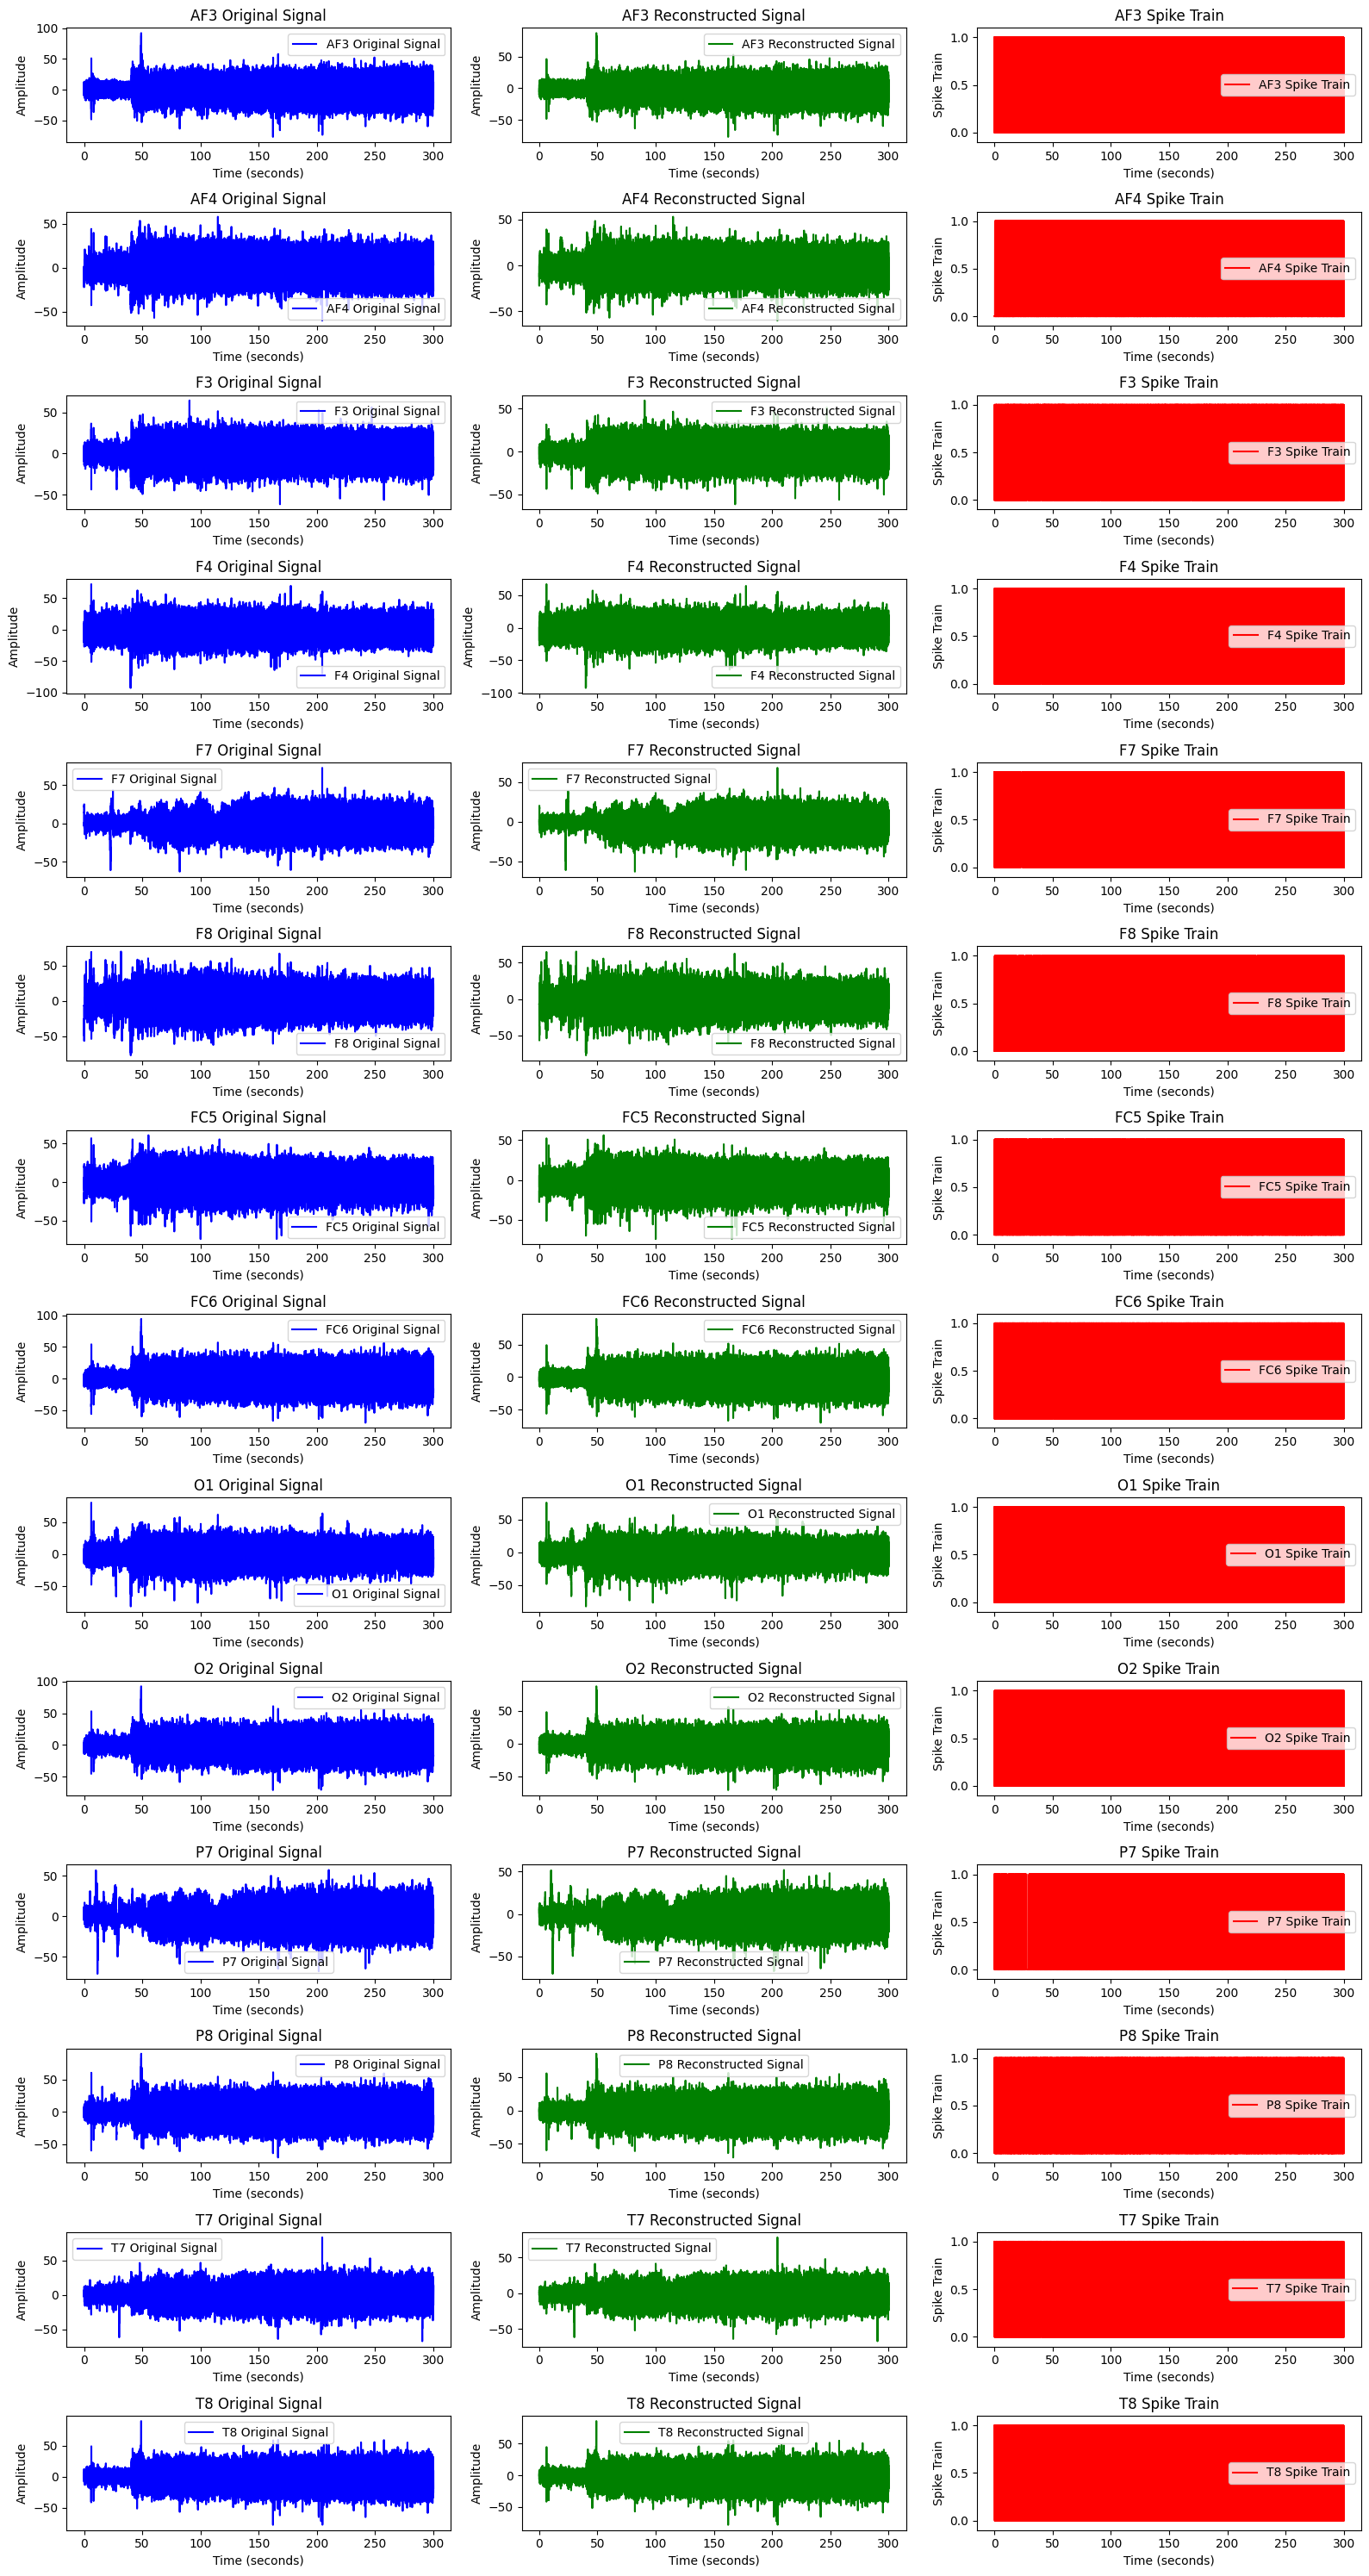

In [7]:
#BSA 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the EEG data
df = pd.read_csv('/kaggle/input/databease-1/databasae/S02G1AllChannels.csv')  # Adjust the file path accordingly
channels = ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']

# Calculate time values based on 300 seconds for 38,252 rows
total_time = 300  # Total duration in seconds
num_rows = len(df)  # Number of rows (38252)
time_step = total_time / num_rows  # Time step per row
time_axis = np.arange(0, total_time, time_step)  # Time array for the x-axis

# BSA Encoding Algorithm (with signal modification)
def BSA_encode(S, filter, thresholdBSA):
    L = len(S)
    F = len(filter)
    B = np.zeros(L - F + 1)  # Initialize binary spike train
    S_modified = np.copy(S)  # Create a copy of the signal to modify

    for t in range(L - F + 1):
        e1 = 0
        e2 = 0
        
        # Calculate e1 and e2
        for k in range(F):
            e1 += np.abs(S_modified[t + k] - filter[k])
            e2 += np.abs(S_modified[t + k])
        
        # Apply the BSA threshold condition
        if e1 <= (e2 - thresholdBSA):
            B[t] = 1
            # Modify the signal after spike detection
            for k in range(F):
                S_modified[t + k] -= filter[k]
    
    return B, S_modified

# Signal Reconstruction from spikes
def reconstruct_signal(S_spikes, filter):
    L = len(S_spikes)
    F = len(filter)
    S_reconstructed = np.copy(S_spikes)  # Copy the signal to modify

    # Add the filter back to the signal where spikes occurred
    for t in range(L - F + 1):
        if S_spikes[t] == 1:  # Reconstruct only where spikes occurred
            for k in range(F):
                S_reconstructed[t + k] += filter[k]
    
    return S_reconstructed

# Define a filter (can be adapted depending on use case)
filter = np.ones(5)  # Example: a simple moving average filter
thresholdBSA = 0.89   # Set an arbitrary threshold

# Plot original, reconstructed signals and spike train for each channel side by side
plt.figure(figsize=(16, 30))

for idx, channel in enumerate(channels):
    eeg_channel_data = df[channel].values
    
    # Apply BSA encoding for the current channel and get the modified signal
    spike_train, modified_signal = BSA_encode(eeg_channel_data, filter, thresholdBSA)
    
    # Reconstruct the signal from the spike train
    reconstructed_signal = reconstruct_signal(modified_signal, filter)
    # Create three subplots for original, reconstructed signals, and spike train
    plt.subplot(14, 3, 3 * idx + 1)
    plt.plot(time_axis, eeg_channel_data, label=f'{channel} Original Signal', color='blue')
    plt.title(f'{channel} Original Signal')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.legend()

    plt.subplot(14, 3, 3 * idx + 2)
    plt.plot(time_axis, reconstructed_signal, label=f'{channel} Reconstructed Signal', color='green')
    plt.title(f'{channel} Reconstructed Signal')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.subplot(14, 3, 3 * idx + 3)

    # Plot the spike train
    plt.plot(time_axis[:len(spike_train)], spike_train, label=f'{channel} Spike Train', color='red')
    plt.title(f'{channel} Spike Train')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Spike Train')
    plt.ylim(-0.1, 1.1)  # Set y-limits for spike train
    plt.legend()

plt.tight_layout()
plt.show()


In [3]:
import os
import numpy as np
import pandas as pd
import zipfile
from tqdm import tqdm  # Import the tqdm library for the progress bar

# Define the input directory for CSV files
input_dir = '/kaggle/input/databease-1/databasae'  # Adjust the path if necessary
output_dir = '/kaggle/working/spike_files/'  # Folder to store the spike CSV files

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define the EEG channels
channels = ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']

# BSA Encoding Algorithm
def BSA_encode(S, filter, thresholdBSA):
    L = len(S)
    F = len(filter)
    B = np.zeros(L - F + 1)  # Initialize binary spike train
    S_modified = np.copy(S)  # Create a copy of the signal to modify

    for t in range(L - F + 1):
        e1 = 0
        e2 = 0
        
        # Calculate e1 and e2
        for k in range(F):
            e1 += np.abs(S_modified[t + k] - filter[k])
            e2 += np.abs(S_modified[t + k])
        
        # Apply the BSA threshold condition
        if e1 <= (e2 - thresholdBSA):
            B[t] = 1
            # Modify the signal after spike detection
            for k in range(F):
                S_modified[t + k] -= filter[k]
    
    return B

# Filter definition and BSA threshold
filter = np.ones(5)  # Example: a simple moving average filter
thresholdBSA = 0.89  # Threshold for BSA

# Get the list of CSV files in the input directory
csv_files = [f for f in os.listdir(input_dir) if f.endswith('.csv')]

# Initialize tqdm for progress tracking
with tqdm(total=len(csv_files), desc="Processing Files") as pbar:
    # Process each file in the input directory
    for filename in csv_files:
        # Load the EEG data for the current file
        file_path = os.path.join(input_dir, filename)
        df = pd.read_csv(file_path)

        # Initialize a DataFrame to store the spike train for all channels
        spike_data = pd.DataFrame()

        # Apply BSA encoding for each channel
        for channel in channels:
            eeg_channel_data = df[channel].values
            spike_train = BSA_encode(eeg_channel_data, filter, thresholdBSA)

            # Pad the spike train to match the original signal length
            padded_spike_train = np.pad(spike_train, (0, len(eeg_channel_data) - len(spike_train)), 'constant')

            # Store the spike train in the DataFrame
            spike_data[channel] = padded_spike_train

        # Save the spike data to a new CSV file
        spike_filename = f"{filename.split('.')[0]}_spike.csv"
        spike_file_path = os.path.join(output_dir, spike_filename)
        spike_data.to_csv(spike_file_path, index=False)

        # Update progress bar after processing each file
        pbar.update(1)

# Zip all the spike files
zip_filename = '/kaggle/working/spike_files.zip'
with zipfile.ZipFile(zip_filename, 'w') as spike_zip:
    for spike_filename in os.listdir(output_dir):
        spike_file_path = os.path.join(output_dir, spike_filename)
        spike_zip.write(spike_file_path, arcname=spike_filename)

print(f"All spike files have been processed and zipped at: {zip_filename}")


Processing Files: 100%|██████████| 112/112 [21:16<00:00, 11.40s/it]


All spike files have been processed and zipped at: /kaggle/working/spike_files.zip


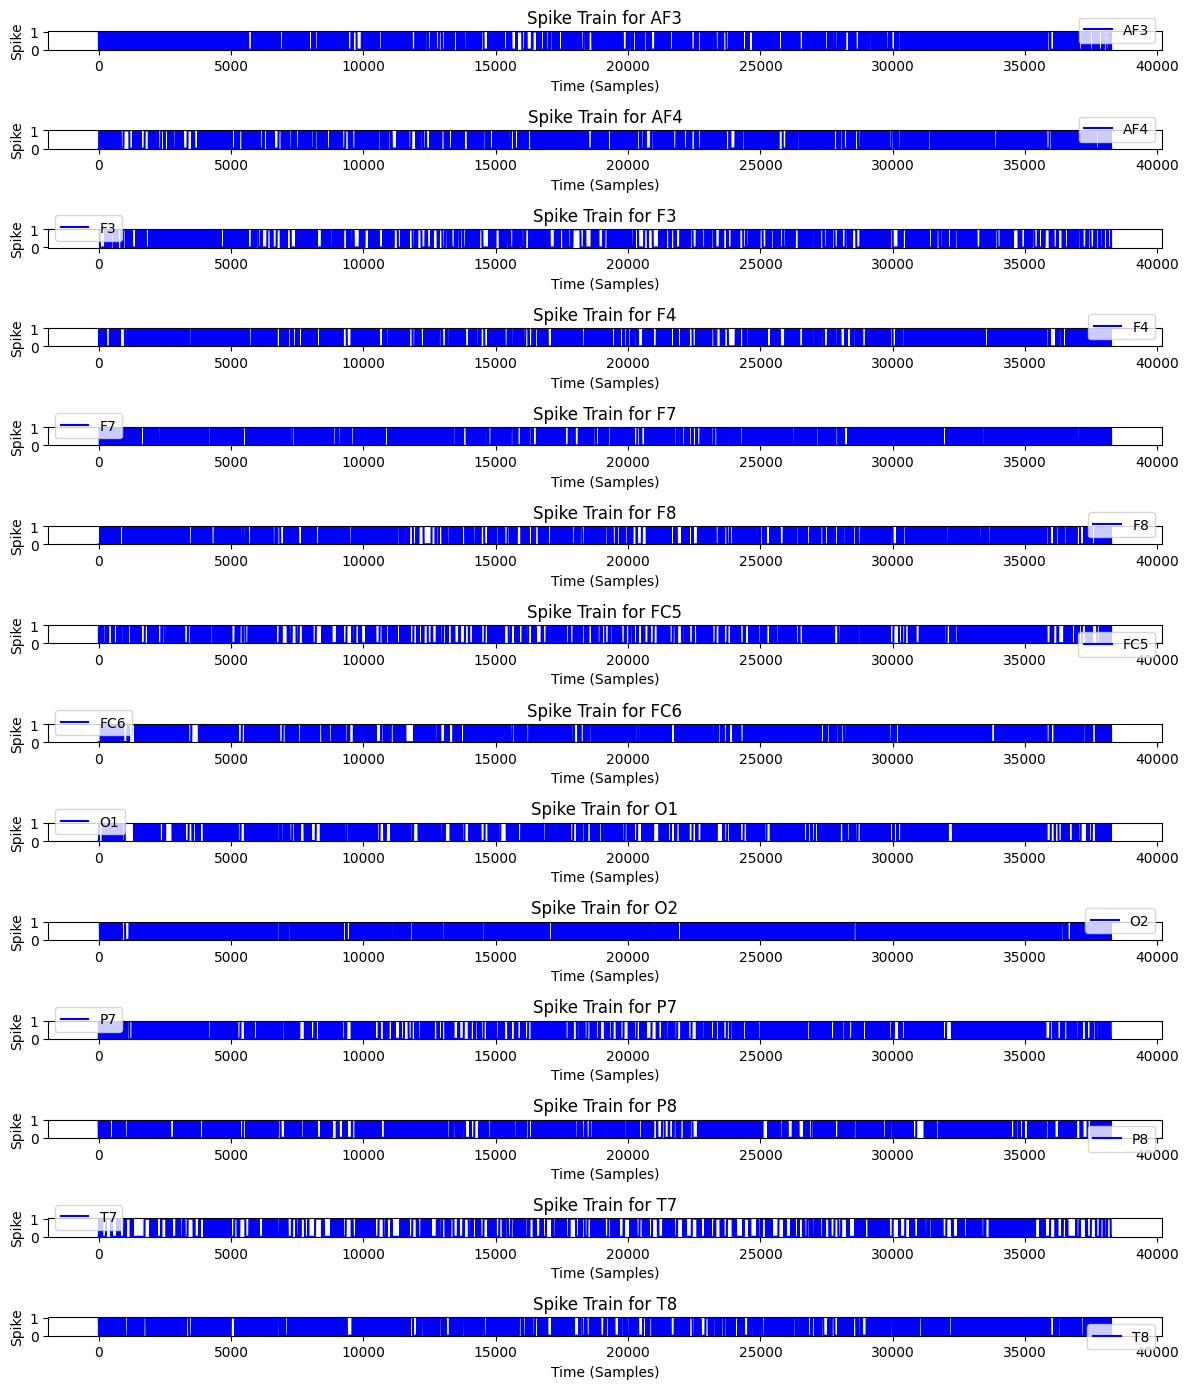

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the spike data from the CSV file
spike_data = pd.read_csv('/kaggle/working/spike_files/S20G3AllChannels_spike.csv')

# Define EEG channels (as columns in the spike file)
channels = ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']

# Plot the spike trains for each channel
plt.figure(figsize=(12, 14))  # Adjust the figure size as needed

for i, channel in enumerate(channels):
    plt.subplot(len(channels), 1, i + 1)
    plt.plot(spike_data[channel], label=channel, color='blue')
    plt.title(f'Spike Train for {channel}')
    plt.xlabel('Time (Samples)')
    plt.ylabel('Spike')
    plt.ylim(-0.001, 1.01)  # Set y-axis limits for spike visualization
    plt.legend()

plt.tight_layout()
plt.show()
